In [5]:
import pandas as pd
import numpy as np

# === 1) Source workbook (where SP500 TR sheets live) ===
src = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis.xlsx"

# === 2) Robust Bloomberg parser (handles duplicate headers & serial dates) ===
def parse_bbg_sheet(df_raw, out_col):
    # find header row containing 'Dates' and 'PX_LAST' (case-insensitive)
    header_row = None
    for i, row in df_raw.iterrows():
        vals = row.astype(str).str.strip().str.upper()
        if ('DATES' in vals.values) and ('PX_LAST' in vals.values):
            header_row = i
            break
    if header_row is None:
        raise ValueError("Could not find 'Dates'/'PX_LAST' header row.")

    # set header & drop earlier rows
    df = df_raw.iloc[header_row:].copy()
    df.columns = df.iloc[0]
    df = df.iloc[1:].copy()

    # drop duplicate columns (e.g., 'Dates', 'Dates.1', 'PX_LAST', 'PX_LAST.1')
    df = df.loc[:, ~df.columns.duplicated()]

    # normalize names
    df.rename(columns={c: str(c).strip() for c in df.columns}, inplace=True)

    # pick date & px columns (tolerate suffixes)
    date_candidates = [c for c in df.columns if c.lower().startswith('dates') or c.lower() == 'date']
    px_candidates   = [c for c in df.columns if c.upper().startswith('PX_LAST')]
    if not date_candidates or not px_candidates:
        raise ValueError(f"Missing date/px columns. Columns found: {list(df.columns)}")

    date_col, px_col = date_candidates[0], px_candidates[0]
    df = df[[date_col, px_col]].copy()
    df.columns = ['Dates', out_col]

    # parse dates: try standard parse, then Excel-serial fallback
    dates_parsed = pd.to_datetime(df['Dates'], errors='coerce')
    mask = dates_parsed.isna()
    if mask.any():
        as_num = pd.to_numeric(df.loc[mask, 'Dates'], errors='coerce')
        if as_num.notna().any():
            dates_parsed.loc[mask & as_num.notna()] = pd.to_datetime('1899-12-30') + pd.to_timedelta(as_num.dropna(), unit='D')

    df['Dates'] = dates_parsed
    df[out_col] = pd.to_numeric(df[out_col], errors='coerce')
    df = df.dropna(subset=['Dates']).set_index('Dates').sort_index()
    return df

# === 3) Load SP500 TR sheets ===
with pd.ExcelFile(src, engine="openpyxl") as xl:
    spx_d_raw = xl.parse("SP500 TR daily",  header=None)
    spx_w_raw = xl.parse("SP500 TR weekly", header=None)

spx_d = parse_bbg_sheet(spx_d_raw, "SP500_TR_Last")
spx_w = parse_bbg_sheet(spx_w_raw, "SP500_TR_Last")

# === 4) Compute log returns (daily & weekly) ===
spx_d['SP500_TR_ret'] = np.log(spx_d['SP500_TR_Last']).diff()
spx_w['SP500_TR_ret'] = np.log(spx_w['SP500_TR_Last']).diff()

spx_d = spx_d.dropna(subset=['SP500_TR_ret'])
spx_w = spx_w.dropna(subset=['SP500_TR_ret'])

# === 5) Save neat outputs (same pattern as Real Estate) ===
out = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_SP500TR_returns.xlsx"
with pd.ExcelWriter(out, engine='openpyxl') as writer:
    spx_d.to_excel(writer, sheet_name="SP500TR daily + ret")
    spx_w.to_excel(writer, sheet_name="SP500TR weekly + ret")

print("✅ S&P 500 TR returns saved to:", out)


✅ S&P 500 TR returns saved to: C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_SP500TR_returns.xlsx


=== Daily S&P 500 TR Log Returns ===
count    2652.000000
mean        0.000496
std         0.011356
min        -0.127605
25%        -0.003400
50%         0.000399
75%         0.005665
max         0.090908
Name: SP500_TR_ret, dtype: float64

=== Weekly S&P 500 TR Log Returns ===
count    530.000000
mean       0.002480
std        0.024104
min       -0.161951
25%       -0.009012
50%        0.004251
75%        0.015438
max        0.114623
Name: SP500_TR_ret, dtype: float64


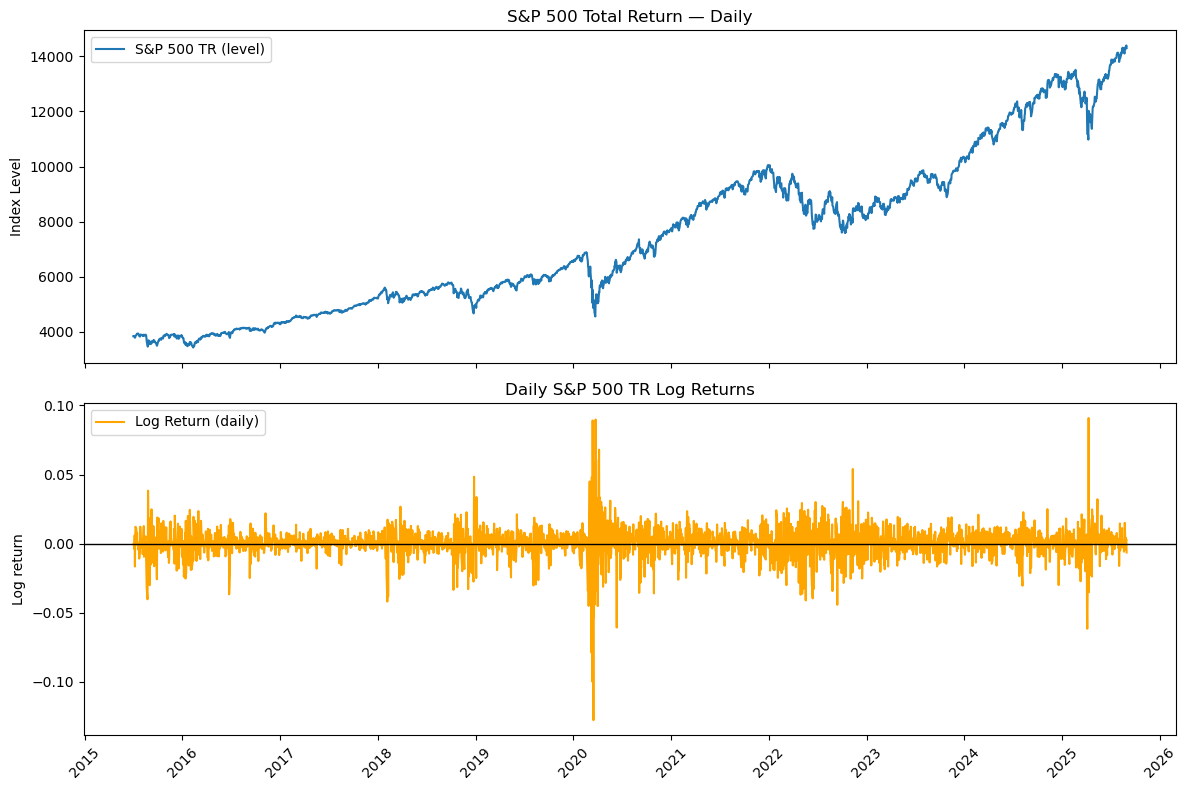

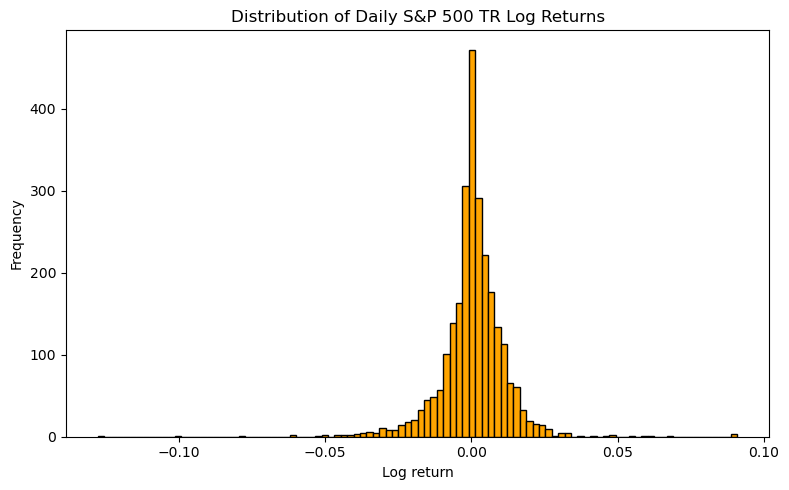

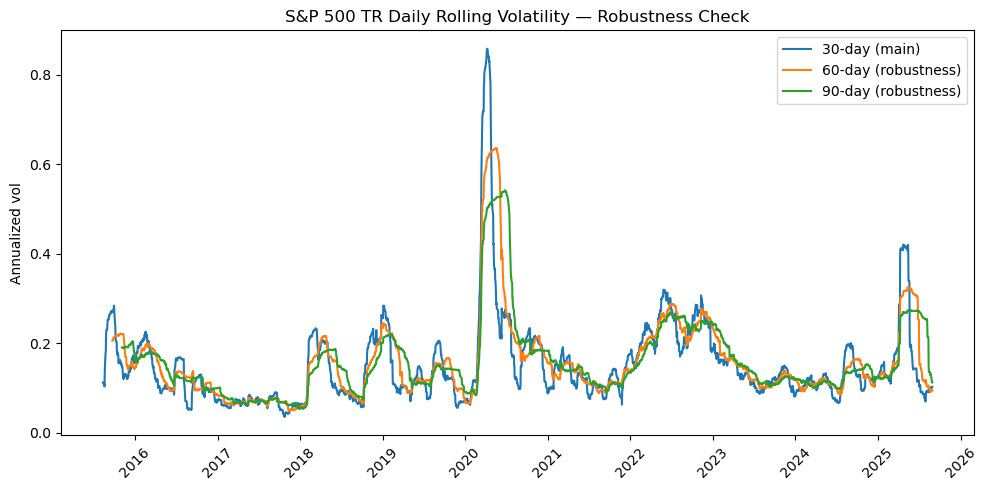

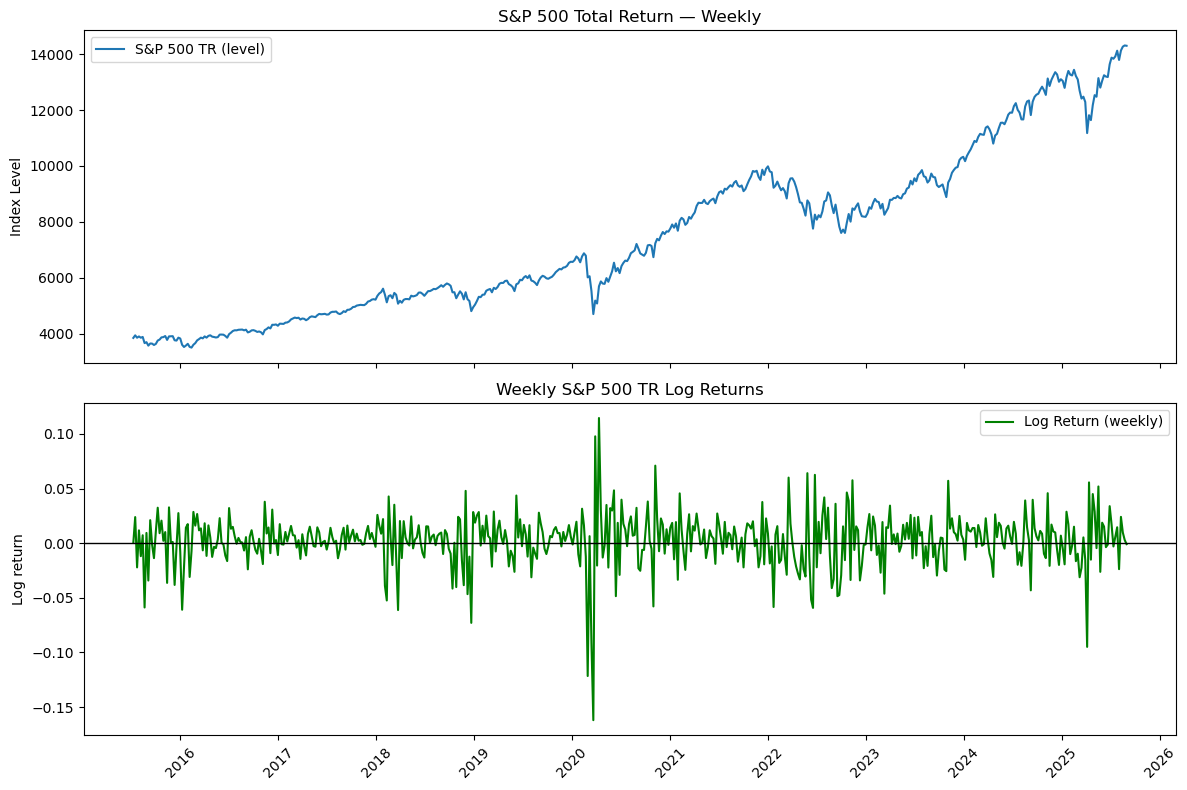

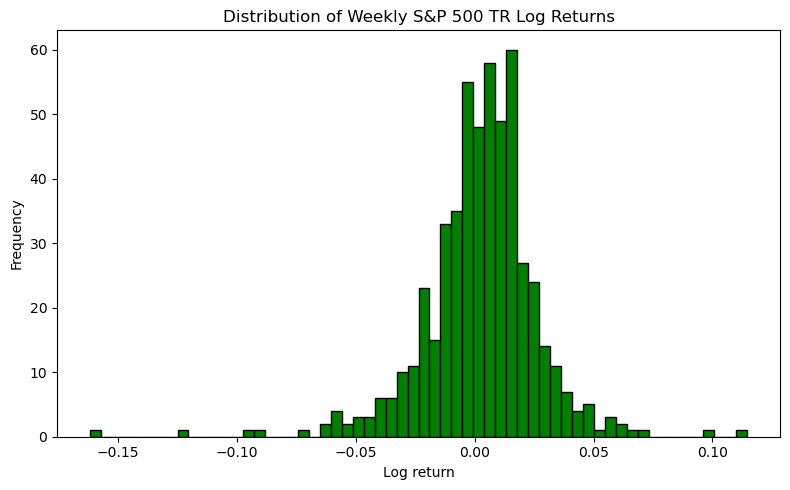

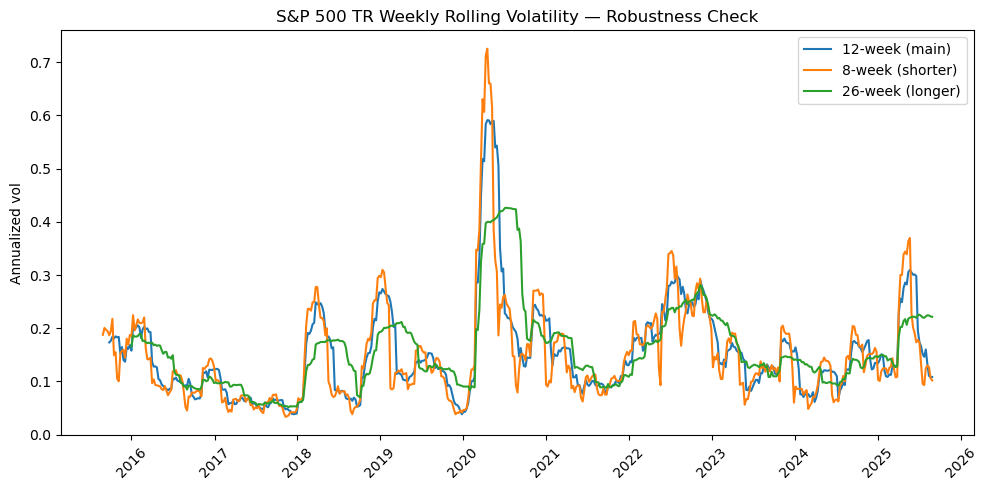

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 1) Load saved S&P 500 TR returns ===
path = r"C:\Users\yanni\OneDrive\Dokumente\Hochschule Luzern Master\Masterarbeit\Data_Masterthesis_SP500TR_returns.xlsx"
spx_d = pd.read_excel(path, sheet_name="SP500TR daily + ret", index_col=0, parse_dates=True)
spx_w = pd.read_excel(path, sheet_name="SP500TR weekly + ret", index_col=0, parse_dates=True)

# === 2) Descriptive statistics ===
print("=== Daily S&P 500 TR Log Returns ===")
print(spx_d['SP500_TR_ret'].describe())
print("\n=== Weekly S&P 500 TR Log Returns ===")
print(spx_w['SP500_TR_ret'].describe())

# === Helper to format x-axis with years ===
def set_year_axis(ax):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.tick_params(axis='x', rotation=45)

# === 3) Daily: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(spx_d.index, spx_d['SP500_TR_Last'], label='S&P 500 TR (level)')
ax[0].set_title('S&P 500 Total Return — Daily')
ax[0].set_ylabel('Index Level'); ax[0].legend(); set_year_axis(ax[0])

ax[1].plot(spx_d.index, spx_d['SP500_TR_ret'], color='orange', label='Log Return (daily)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Daily S&P 500 TR Log Returns')
ax[1].set_ylabel('Log return'); ax[1].legend(); set_year_axis(ax[1])

plt.tight_layout(); plt.show()

# === 4) Daily histogram ===
plt.figure(figsize=(8,5))
plt.hist(spx_d['SP500_TR_ret'].dropna(), bins=100, color='orange', edgecolor='black')
plt.title('Distribution of Daily S&P 500 TR Log Returns')
plt.xlabel('Log return'); plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# === 5) Daily rolling vol (30/60/90 d), annualized √252 ===
spx_d['RollingVol30'] = spx_d['SP500_TR_ret'].rolling(30).std()
spx_d['RollingVol60'] = spx_d['SP500_TR_ret'].rolling(60).std()
spx_d['RollingVol90'] = spx_d['SP500_TR_ret'].rolling(90).std()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(spx_d.index, spx_d['RollingVol30'] * np.sqrt(252), label='30-day (main)')
ax.plot(spx_d.index, spx_d['RollingVol60'] * np.sqrt(252), label='60-day (robustness)')
ax.plot(spx_d.index, spx_d['RollingVol90'] * np.sqrt(252), label='90-day (robustness)')
ax.set_title('S&P 500 TR Daily Rolling Volatility — Robustness Check')
ax.set_ylabel('Annualized vol'); ax.legend(); set_year_axis(ax)
plt.tight_layout(); plt.show()

# === 6) Weekly: price & returns ===
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(spx_w.index, spx_w['SP500_TR_Last'], label='S&P 500 TR (level)')
ax[0].set_title('S&P 500 Total Return — Weekly')
ax[0].set_ylabel('Index Level'); ax[0].legend(); set_year_axis(ax[0])

ax[1].plot(spx_w.index, spx_w['SP500_TR_ret'], color='green', label='Log Return (weekly)')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('Weekly S&P 500 TR Log Returns')
ax[1].set_ylabel('Log return'); ax[1].legend(); set_year_axis(ax[1])

plt.tight_layout(); plt.show()

# === 7) Weekly histogram ===
plt.figure(figsize=(8,5))
plt.hist(spx_w['SP500_TR_ret'].dropna(), bins=60, color='green', edgecolor='black')
plt.title('Distribution of Weekly S&P 500 TR Log Returns')
plt.xlabel('Log return'); plt.ylabel('Frequency')
plt.tight_layout(); plt.show()

# === 8) Weekly rolling vol (12/8/26 w), annualized √52 ===
spx_w['RollingVol12w'] = spx_w['SP500_TR_ret'].rolling(12).std()
spx_w['RollingVol8w']  = spx_w['SP500_TR_ret'].rolling(8).std()
spx_w['RollingVol26w'] = spx_w['SP500_TR_ret'].rolling(26).std()

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(spx_w.index, spx_w['RollingVol12w'] * np.sqrt(52), label='12-week (main)')
ax.plot(spx_w.index, spx_w['RollingVol8w']  * np.sqrt(52), label='8-week (shorter)')
ax.plot(spx_w.index, spx_w['RollingVol26w'] * np.sqrt(52), label='26-week (longer)')
ax.set_title('S&P 500 TR Weekly Rolling Volatility — Robustness Check')
ax.set_ylabel('Annualized vol'); ax.legend(); set_year_axis(ax)
plt.tight_layout(); plt.show()
